# Post-processing and visualization of IAMC format data using *pyam*
This tutorial provides a quick overview of some of features of *pyam* package. For more information about the package and its capabilities please visit [pyam webpages](https://pyam-iamc.readthedocs.io/). For example, you can find many [useful tutorials](https://pyam-iamc.readthedocs.io/en/stable/tutorials.html) and examples on how to use the package for post-processing and plotting.

This tutorial is based on data retrieved from [Scenario Explorer](https://internal.ecemf.iiasa.ac.at/) for the [ECEMF](https://www.ecemf.eu/) (European Energy and Climate Modeling Forum) project. For more information on this tutorial, please contact: [Behnam Zakeri](https://iiasa.ac.at/staff/behnam-zakeri).
For running this tutorial, you need:

- Python (version >3.7.1 and <3.11) installed on your machine (see installation [here](https://www.python.org/downloads/))
- Jupyter, for running this Notebook (see instructions [here](https://jupyter.org/install))
- *pyam* (see instructions [here](https://pyam-iamc.readthedocs.io/en/stable/install.html))
- access to a Scenario Explorer instance, or loading IMAC format data from a CSV file on your machine.

## Step 1) Importing *pyam* and connecting to Scenario Explorer
After establishing the connection to the database, importing data may take a few seconds to minutes depending on the size of data. You can store the data as a CSV file on your machine and use it later.


In [1]:
import pyam
from matplotlib import pyplot as plt
# Reading data from Scenario Explorer (True) or from an existing CSV file (False)
from_scenario_explorer = False

# Specify a path and a file name to save or to load raw data from SE
file_path = r"C:\Users\...\ECEMF\WP2"  # Notice: Update this for a path on your machine
file_name = "\\snapshot_eu_sectoral.csv"

<IPython.core.display.Javascript object>

In [2]:
if from_scenario_explorer:
    # Configuring a username/password (the same as your log in info to SE)
    pyam.iiasa.set_config("johnsmith", "!!!")

    # Make a connection to IIASA Scenario Explorer (SE) instances
    conn = pyam.iiasa.Connection()

    # See possible databases, from which you can import data
    conn.valid_connections

    # Establishing connection to a specific SE (e.g., "ecemf_internal")
    ecemf = pyam.iiasa.Connection('ecemf_internal')
    
    # Alternative I) Loading data from IIASA's SE, by filtering specific scenarios (this may take a few minutes)
    data = ecemf.query(scenario=["WP2*"])

    # Saving data to CSV for preventing loading from IIASA's SE each time
    data.to_csv(file_path + file_name)

## Step 2) Loading data and filtering
You can load data directly from Scenario Explorer (as shown above) or opening a CSV file on your machine.

In [ ]:
# Alternative II) Loading data from a snapshot (CSV file) (it's faster than loading data from SE)
if not from_scenario_explorer:
    data = pyam.IamDataFrame(data=file_path + file_name)

For filtering data, i.e., choosing models, scenarios, regions, variables, or years you can pass strings in full or partially.

In [4]:
# Filtering data for a selected criteria
eu = data.filter(region=["EU27"], variable=["Final Energy|Transport*"])

# Filter out sensitivity scenarios by using "keep=False"
eu = eu.filter(scenario=["WP2 Sensitivity*", "*Boundary*"], keep=False)
                
# Filter out irrelevant models ("REMIND-Building" and "REMIND-Industry" in transport data!)
eu = eu.filter(model=["*Building*", "*Industry*"], keep=False)

# Check models, scenarios, and variables included in the filtered data (e.g., eu.scenario)
eu.model

['EDGE-T 0.15.0', 'PRIMES-TREMOVE 2021']

**Notice**: You can convert pyam.IamDataFrame data to timeseries, by using `df = eu.timeseries()`, and look into the table (DataFrame). Also, you can use all python features for DataFrame, but usig pyam is usually easier for working with IAMC format data.

## Step 3) Postprocessing and Visualization
Here are a few examples showing how you can:
- visualize, group scenarios, and use different plots
- change color of plots
- rename/shorten the legend
- calculate shares
- aggregate data and create new variables

In [5]:
# Import a method for legend position for visualization
from pyam.plotting import OUTSIDE_LEGEND

### 3.1) Simple plotting and grouping

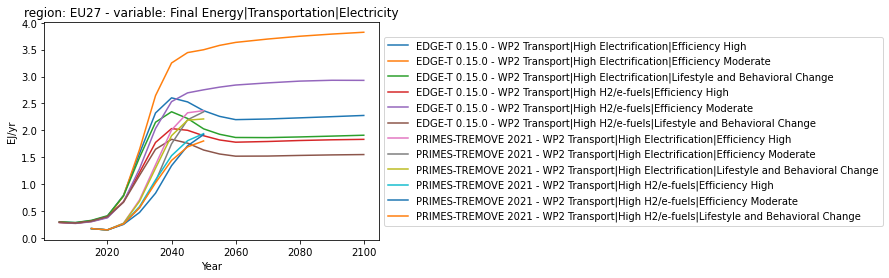

In [6]:
# Filter certain variable(s) and scenarios
df = eu.filter(variable="Final Energy|Transportation|Electricity")

# Plot and put legend outside
ax = df.plot(legend=OUTSIDE_LEGEND["right"])

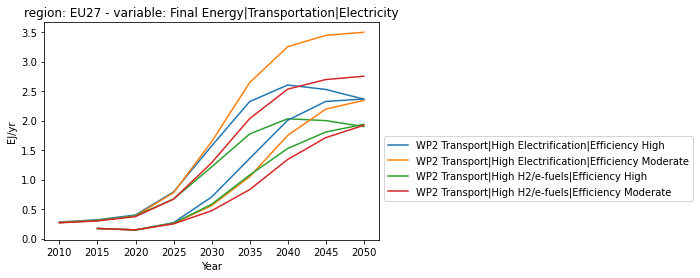

In [7]:
# Plot certain scenarios by grouping them for all models in the same color and limiting years to 2050
ax = df.filter(scenario="*Efficiency*", year=range(2010, 2051)).plot(color="scenario", legend=OUTSIDE_LEGEND["right"])

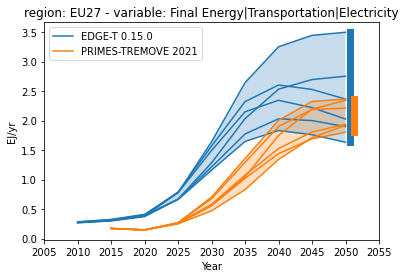

In [8]:
# Plot all scenarios by grouping models, filling between the ranges, and adding bars for final ranges
ax = df.filter(year=range(2010, 2051)).plot(color="model", fill_between=True, final_ranges=dict(linewidth=7),
                                            legend=dict(loc="upper left"))

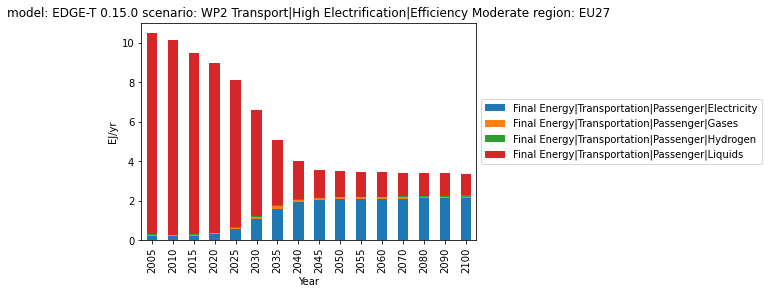

In [9]:
# Plot data in the stacked bar format
df = eu.filter(model=["EDGE-T 0.15.0"],
               variable="Final Energy|Transportation|Passenger|*",
               scenario="*High Electrification|Efficiency Moderate",
              )
ax = df.plot.bar(stacked=True, legend=OUTSIDE_LEGEND["right"])

### 3.2) Renaming legend entries and changing colors
Sometimes, the legends can be too long and it is desired to shorten or even rename them. Also, you can change the color of the plots based on scenarios, models, regions, or variables. Here are a couple of examples how to do that.

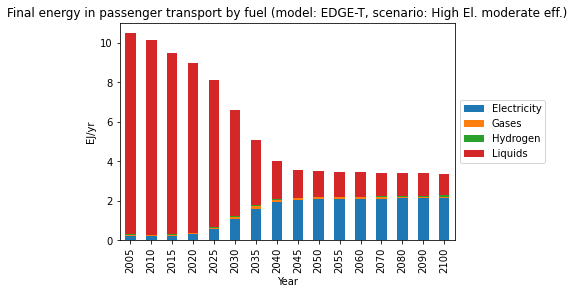

In [10]:
# Let's plot previous data in the stacked bar format with shortened/renamed legend
rename_map = {v: v.replace("Final Energy|Transportation|Passenger|", "") for v in df.variable}
ax = df.rename(variable=rename_map).plot.bar(stacked=True, legend=dict(loc="upper right"),
            title="Final energy in passenger transport by fuel (model: EDGE-T, scenario: High El. moderate eff.)")

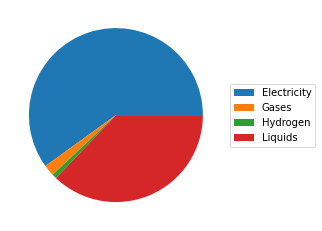

In [11]:
# Plot for one specific year (pie chart)
ax = df.rename(variable=rename_map).filter(year=2050).plot.pie(labels=None, legend=True)

**Changing colors**

This is sometimes desirable to change the color and use a consistent color code across all plots. This is possible using *pyam* feature of `run_control()` (see moredetails [here](https://pyam-iamc.readthedocs.io/en/stable/api/plotting.html#the-runcontrol-configuration). Simply, the user needs to specify color codes for regions, scenarios, or variables in a dictionary or in a separate yaml file. Here, we make an example by setting variable colors through a python dictionary.

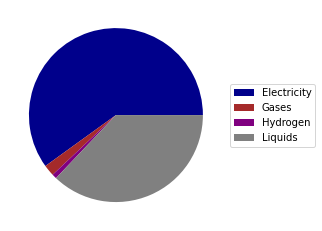

In [12]:
# Chaning the color of variables
color_map = {"Electricity": "darkblue", "Gases": "brown", "Hydrogen": "purple", "Liquids": "grey"}
pyam.run_control().update({"color": {"variable": color_map}})
ax = df.rename(variable=rename_map).filter(year=2050).plot.pie(labels=None, legend=True)

**Important**: You can always convert pyam.IamDataFrame to a python DataFrame using `timeseries()` method. Then, you will be able to use all plotting features of python. Of course, this requires a bit of more cleanup after plotting, like specifying title, labels, etc., which *pyam* usually does this automatically. But for certain plot types, it may be useful to use python.

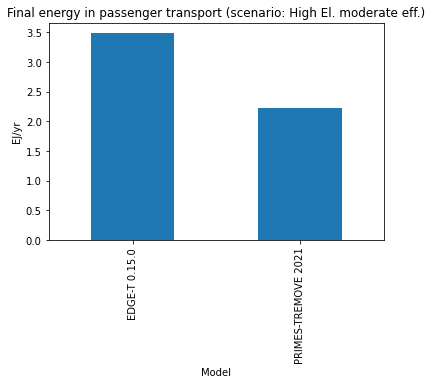

In [13]:
# Plot data in the bar format
df = eu.filter(variable="Final Energy|Transportation|Passenger",
               scenario="*High Electrification|Efficiency Moderate",
               year=2050,
              ).filter(variable="Final Energy|Transportation|Passenger|Liquids|*", keep=False)
ax = df.plot.bar(x="model", title="Final energy in passenger transport (scenario: High El. moderate eff.)", legend=False)

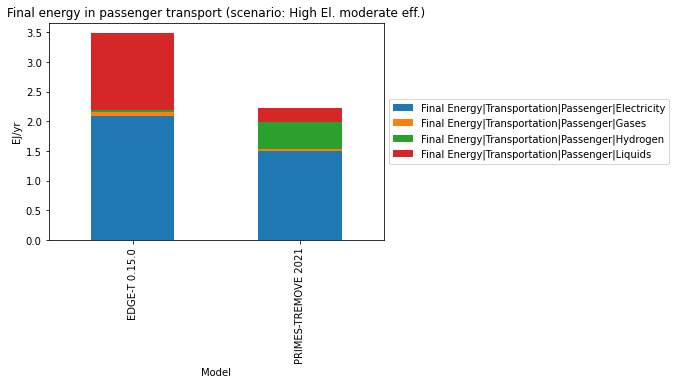

In [14]:
# Plot data in the stacked bar format
df = eu.filter(variable="Final Energy|Transportation|Passenger|*",
               scenario="*High Electrification|Efficiency Moderate",
               year=2050,
              ).filter(variable="Final Energy|Transportation|Passenger|Liquids|*", keep=False)
# Rename variables for the legend
rename_map = {v: v.replace("Final Energy|Transportation|Passenger|", "") for v in df.variable}
ax = df.plot.bar(stacked=True, x="model", title="Final energy in passenger transport (scenario: High El. moderate eff.)")

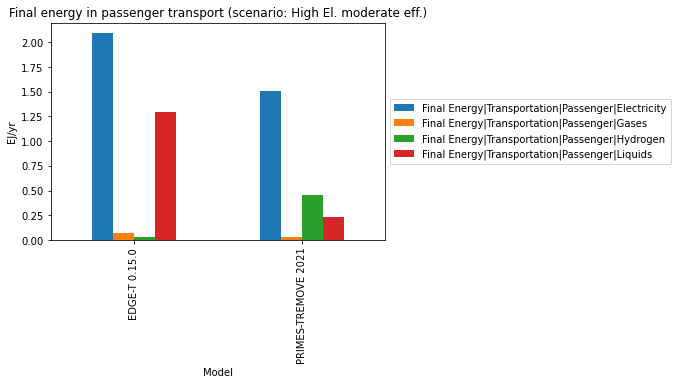

In [15]:
# Plot data in bar format but not stacked
ax = df.plot.bar(x="model", title="Final energy in passenger transport (scenario: High El. moderate eff.)")

### 3.3) Calculating a share
*pyam* has made the calculation of the shares very easy; you only need to specify the variables in the nominator (share) and denominator (total), and give a new variable name for calculated share. *pyam* calculates the correct unit automatically.

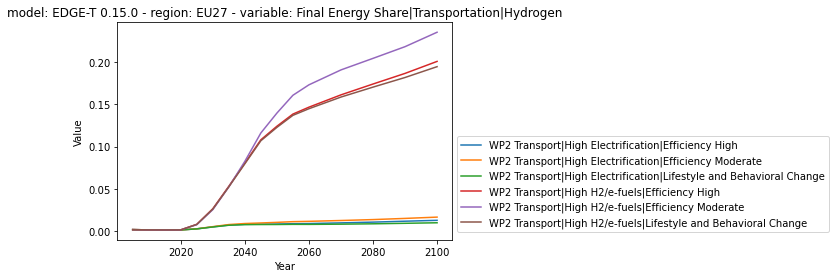

In [16]:
# Calculating a share (e.g., share of hydrogen from total final energy in transportation)
df = eu.filter(model=["EDGE-T 0.15.0"]) 
share = df.divide("Final Energy|Transportation|Hydrogen",   # nominator
                  "Final Energy|Transportation",            # denomanitor
                  "Final Energy Share|Transportation|Hydrogen",  # new variable name for share
                  )

# Visualization
ax = share.plot(legend=OUTSIDE_LEGEND["right"])

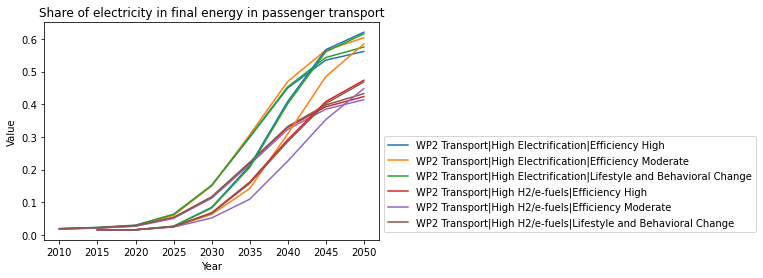

In [17]:
# Calculating and comparing a share for several models
df = eu.filter(year=range(2010, 2051))
share = df.divide("Final Energy|Transportation|Electricity",   # nominator
                  "Final Energy|Transportation",            # denomanitor
                  "Final Energy Share|Transportation|Electricity",  # new variable name for share
                  )

# Visualization
ax = share.plot(title="Share of electricity in final energy in passenger transport",
                legend=OUTSIDE_LEGEND["right"], color="scenario")

In [20]:
# Calculating shares for a few commodities in different sectors
commodity_list = ["Electricity", "Hydrogen"]
node = "EU27"
yr = [2050]  # can be more than one year
df = data.filter(year=yr, region=node).filter(scenario=["*Boundary*", "*Sensitivity*"], keep=False)

# Calculating shares in a loop for each sector
sectors = {"Industry": "Industry",
           "Residential and Commercial": "Building",
           "Transportation": "Transport"}
shares = []
for sec, scen in sectors.items():
    for comm in commodity_list:
        # Calculating share
        share = df.divide("Final Energy|" + sec + "|" + comm,   # nominator
                          "Final Energy|" + sec,            # denomanitor
                          "Final Energy Share|" + sec + "|" + comm,  # new variable name for share
                          )
        # Rename/shorten scenario names
        rename_map = {s: s.replace("WP2 " + sectors[sec] + "|", "") for s in share.scenario}
        share = share.rename(scenario=rename_map)

        # Putting DH at the end of scenarios (ToDo: a cleaner way will be to do this by reordering!)
        rename_map = {s: s.replace("District Heating", "RC-District Heating") for s in share.scenario}
        share = share.rename(scenario=rename_map)

        # Excluding REMIND mismtahced model names
        exclude = [x for x in sectors.values() if x != sectors[sec]]
        for ex in exclude:
            share = share.filter(scenario="WP2 " + ex + "*", keep=False)

        shares.append(share)

df_sh = pyam.concat(shares)

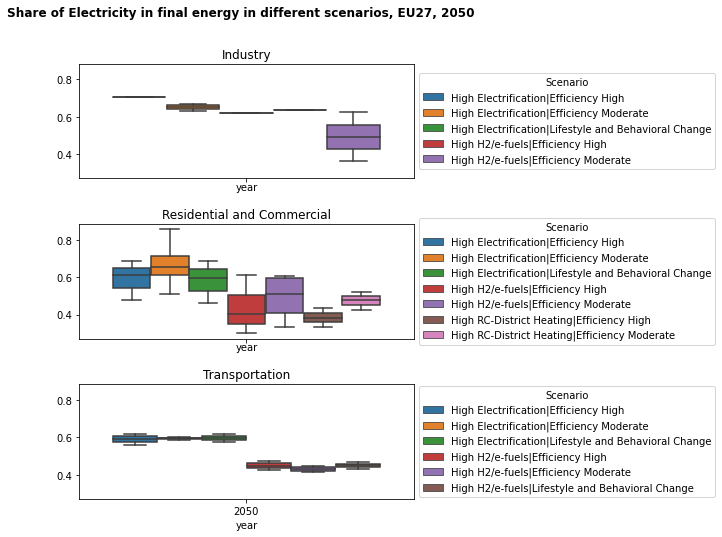

In [33]:
# Comparing the share of a commodity for all scenarios
commodity = "Electricity"

# Plotting boxes for each scenario (including all models)
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(6, 8))
fig.subplots_adjust(hspace=0.4)
fig.suptitle("Share of " + commodity + " in final energy in different scenarios, " + node + ", " + str(yr), fontweight="bold")
for x, (sector, ax) in enumerate(zip(sectors.keys(), axes.reshape(-1))):
    df_sh.filter(variable="Final Energy Share|" + sector + "|" + commodity).plot.box(ax=ax, by="scenario", title=sector)
    # Legend
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), title="Scenario")

### Renaming models and assigning specific colors to them

In [35]:
# Renaming models
rename_model = {
    'EDGE-T 0.15.0': 'EDGE-T',
    'FORECAST v1.0': 'FORECAST',
    'Invert/EE-Lab 4.2': 'Invert/EE-Lab',
    'Invert/Opt 1.0': 'Invert/Opt',
    'PRIMES-Buildings 2022': 'PRIMES-Buildings',
    'PRIMES-Industry 2022': 'PRIMES-Industry',
    'PRIMES-TREMOVE 2021': 'PRIMES-TREMOVE',
    'WITCH 5.1': 'WITCH',
    }
df_sh = df_sh.rename(model=rename_model)

In [36]:
# Assigning a specific color to each model
color_model = {
        'EDGE-T': 'coral',
        'FORECAST': 'orangered',
        'Invert/EE-Lab': 'darkviolet',
        'Invert/Opt': 'violet',
        'PRIMES-Buildings': 'teal',
        'PRIMES-Industry': 'slateblue',
        'PRIMES-TREMOVE': 'cadetblue',
        'WITCH': 'limegreen',
        }
# Updating pyam for the color of models
pyam.run_control().update({"color": {"model": color_model}})

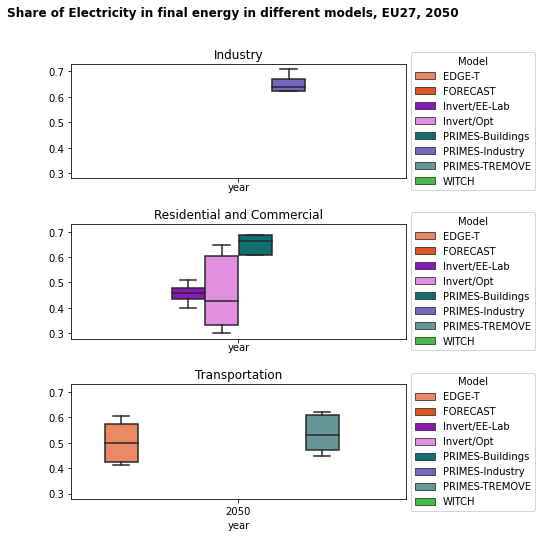

In [41]:
# Comparing the share of a commodity for all sectoral models
commodity = "Electricity"
# Plotting boxes for each model (including all scenarios)
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(6, 8))
fig.subplots_adjust(hspace=0.4)
fig.suptitle("Share of " + commodity + " in final energy in different models, " + node + ", " + str(yr), fontweight="bold")
for x, (sector, ax) in enumerate(zip(sectors.keys(), axes.reshape(-1))):
    df_sh.filter(variable="Final Energy Share|" + sector + "|" + commodity).plot.box(ax=ax, by="model", title=sector)
    # Legend
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), title="Model")

In [22]:
# Check why some models are missing for "Hydrogen"
d = df.filter(model=["*Invert*"], variable="*Hydrogen*")
d.variable

['Emissions|CO2|Energy|Supply|Hydrogen']

#### 3.4) Aggregation of data
You can aggregate the data for some sub-categories, if that aggregation is not available in the data, or if you wish to recalculate/check that. For example, "Gases" as an aggregate is not reported in the data below, and we calculate that.

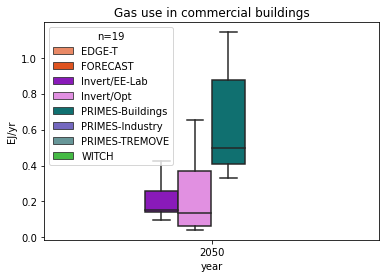

In [44]:
# Filter data for the commercial sector
data = data.rename(model=rename_model)
comm = data.filter(scenario=["WP2 Building*"], variable=["Final Energy|Commercial*"])

# Aggregation of all sub-categories of gases for the commercial sector
comm.aggregate("Final Energy|Commercial|Gases", append=True)

# Visualization with box plots
plot_title = "Gas use in commercial buildings"
ax = comm.filter(variable="Final Energy|Commercial|Gases", year=2050
                ).plot.box(x="year", by="model", title=plot_title)

### 3.5) Plotting two variables against each other

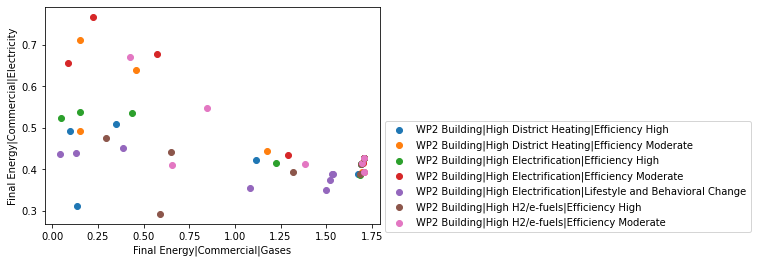

In [28]:
# Plot "Gases" against "Electricity", group by scenario for all models
ax = comm.plot.scatter(x="Final Energy|Commercial|Gases",
                       y="Final Energy|Commercial|Electricity",
                       color="scenario", legend=OUTSIDE_LEGEND["right"])

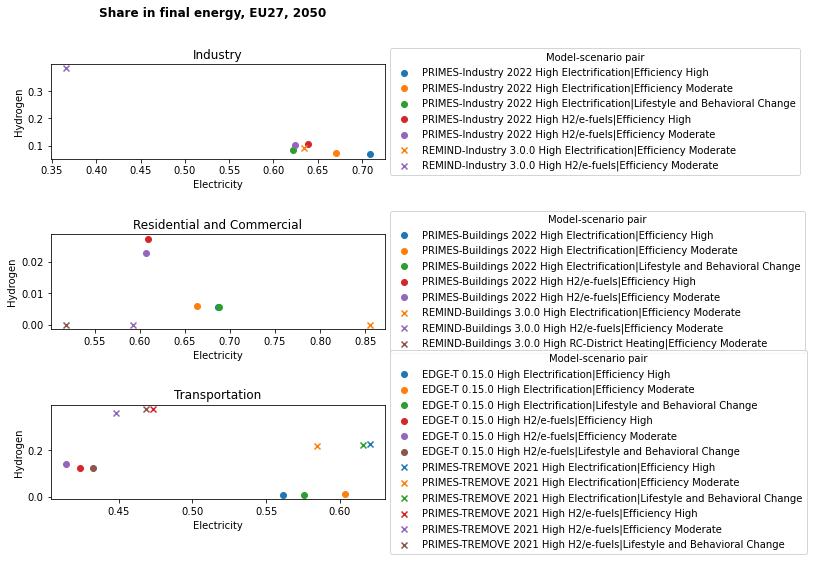

In [29]:
# Plotting share of two commodities against each other for model-scenario pairs
com1 = "Electricity"
com2 = "Hydrogen"
yr = 2050
fig, axes = plt.subplots(3, 1, figsize=(6, 8))
fig.subplots_adjust(hspace=0.8)
fig.suptitle("Share in final energy, " + node + ", " + str(yr), fontweight="bold")

# Plotting in a for loop for each sector
for x, (sector, ax) in enumerate(zip(sectors.keys(), axes.reshape(-1))):
    df_sh.filter(year=yr).plot.scatter(ax=ax, title=sector, color="scenario", marker="model",
        x="Final Energy Share|" + sector + "|" + com1,
        y="Final Energy Share|" + sector + "|" + com2,
                                      )
    # Labels and legend               
    ax.set_xlabel(com1), ax.set_ylabel(com2)
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), title="Model-scenario pair")

### Congratulations! 
You are an expert *pyam* user. For more features, please visit [pyam's plotting gallery](https://pyam-iamc.readthedocs.io/en/stable/gallery/index.html). 